In [1]:
#Cell 1
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
working_dir = '/content/drive/MyDrive/GT_coursework/Fall 24/Deep Reinforcement Learning/paper_presentation/MBPO_pendulumV1/MBPO_pendulumV1'
%cd $working_dir

/content/drive/MyDrive/GT_coursework/Fall 24/Deep Reinforcement Learning/paper_presentation/MBPO_pendulumV1/MBPO_pendulumV1


In [3]:
!pip install gymnasium[classic_control]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 39.8 MB/s eta 0:00:00


In [24]:
import gymnasium as gym
from modelbased import ModelAgent
import random
import numpy as np
import torch
from gymnasium.wrappers import RecordVideo
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd


In [5]:
from demo import scale_action

In [11]:
def run_episode(env, agent):
    """
    Runs a single episode in the gym environment using the policy agent.

    Parameters:
    env (gym.Env): The environment to run the episode in.
    agent (ModelAgent): The agent that interacts with the environment.

    Returns:
    float: The total reward accumulated during the episode.
    """
    obs, info = env.reset()
    reward_tot = 0.0
    done = False
    reward = 0.0

    reward_history = []  # Initialize an empty list to store rewards
    # Loop until the episode is not terminated or truncated
    while not done:
        # Get the action from the agent and scale it to the environment's action space
        action = scale_action(env, agent.step(obs, reward))

        # Take a step in the environment using the scaled action
        obs, reward, terminated, truncated, info = env.step(action)
        reward_history.append(reward)  # Append the reward to the list

        # Check if the episode is terminated or truncated
        done = terminated or truncated

        # Accumulate the reward (no discounting for simplicity)
        reward_tot += reward
    agent.step(obs, reward)
    agent.reset()
    return reward_tot


In [12]:

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

env = gym.make("Pendulum-v1", render_mode='rgb_array')
env = RecordVideo(env, video_folder='logging/', episode_trigger=lambda episode_id: True)
agent = ModelAgent(env.observation_space.shape[0], env.action_space.shape[0])
reward_histories = []
for i in range(2):
    # Run a single episode and get the total reward
    reward_tot,reward_history = run_episode(env, agent)
    reward_histories.append(reward_history)
    print("Episode:", i + 1, "--- Total Reward:", reward_tot)
env.close()

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


Performing update steps...
Episode: 1 --- Total Reward: -1493.300073008909
Performing update steps...
Performing update steps...
Performing update steps...
Performing update steps...
Episode: 2 --- Total Reward: -1296.2130516684178


In [13]:
from IPython.display import HTML
from base64 import b64encode

def display_video(file_path):
    # Read the video file and convert it to a format that can be displayed in the notebook
    video = open(file_path, "rb").read()
    video_encoded = b64encode(video).decode('ascii')
    video_tag = f'''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
    </video>
    '''
    return HTML(video_tag)

In [14]:
display_video('example_video/ep5.mp4')

In [15]:
history = reward_histories[0]


In [19]:
def plot_rewards(rwds,names):
  fig = plt.figure()
  plt.plot(rwds)
  plt.xlabel('Episode')
  plt.ylabel('Rewards')
  plt.title('Rewards')
  plt.show()

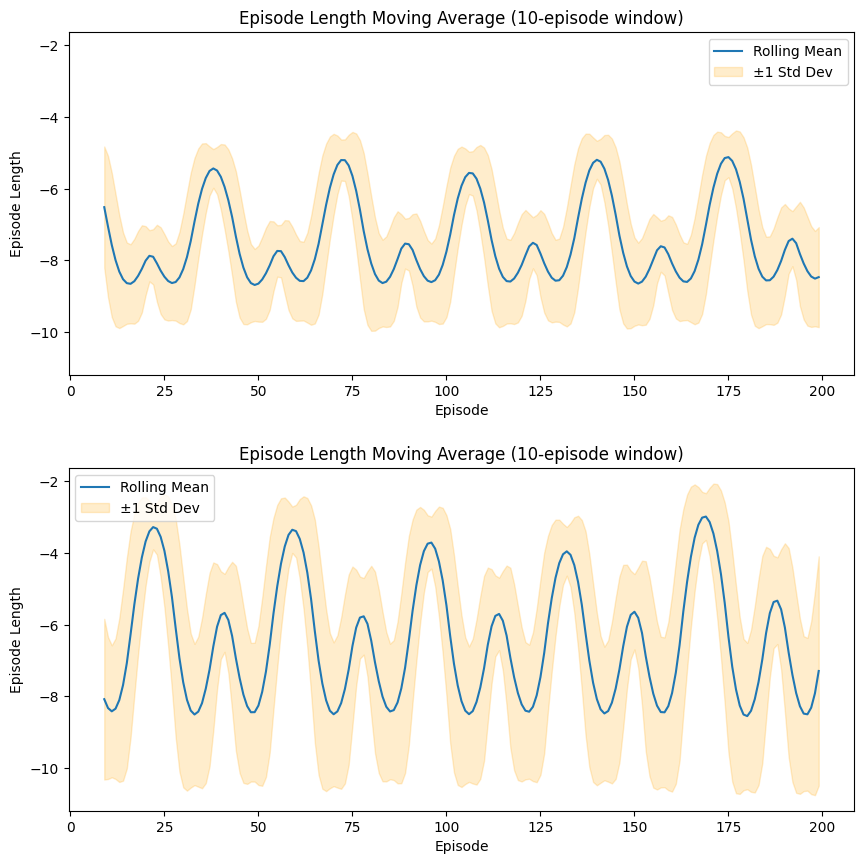

In [18]:
# Define window size for moving average and standard deviation
window = 10

# Create subplots with shared y-axis
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate rolling mean and standard deviation
rolling_mean = pd.Series(history).rolling(window).mean()
std = pd.Series(history).rolling(window).std()

# Plot rolling mean with standard deviation bands
ax1.plot(rolling_mean, label='Rolling Mean')
ax1.fill_between(range(len(history)), rolling_mean - std, rolling_mean + std, color='orange', alpha=0.2, label='±1 Std Dev')
ax1.set_title(f'Reward ({window}-episode window)')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')
ax1.legend()

# # Plot the actual reward history
# ax2.plot(history, label='Reward History')
# ax2.set_title('Episode Length')
# ax2.set_xlabel('Episode')
# ax2.set_ylabel('Episode Length')
# ax2.legend()
# Plot rolling mean with standard deviation bands
history = reward_histories[1]

rolling_mean = pd.Series(history).rolling(window).mean()
std = pd.Series(history).rolling(window).std()
ax2.plot(rolling_mean, label='Rolling Mean')
ax2.fill_between(range(len(history)), rolling_mean - std, rolling_mean + std, color='orange', alpha=0.2, label='±1 Std Dev')
ax2.set_title(f'Episode Length Moving Average ({window}-episode window)')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')
ax2.legend()


# Adjust the layout to avoid overlap
fig.tight_layout(pad=2)

# Show the plot
plt.show()

In [ ]:
plot_rewards(reward_histories)

In [22]:
def plot_histories(history_means, history_stds, history_names):
    for history_mean, history_std, history_name in zip(history_means, history_stds, history_names):
        plt.plot(history_mean, label=history_name)
        plt.fill_between(range(len(history_mean)), np.array(history_mean) - np.array(history_std), np.array(history_mean) + np.array(history_std), alpha=0.2)
    plt.title(f'Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()

In [21]:
def dummy_reward_history(add_term,multiply_term):
    # emulate a noisy saturating reward history higher add_term means higher reward
    # higher multiply_term means faster saturation
    history_mean = []
    history_std = []
    for i in range(100):
        history_mean.append(add_term*(1-np.exp(-multiply_term*i)) + random.random())
        # std is noisily proportional to the mean
        std = history_mean[-1]*0.1+random.random()*0.01
        history_std.append(std)

    return history_mean, history_std

history_mean1, history_std1 = dummy_reward_history(10,0.1)
history_mean2, history_std2 = dummy_reward_history(15,0.15)
history_mean3, history_std3 = dummy_reward_history(20,0.2)
history_means = [history_mean1, history_mean2, history_mean3]
history_stds = [history_std1, history_std2, history_std3]
history_names = ['K=1', 'K=2', 'K=3']

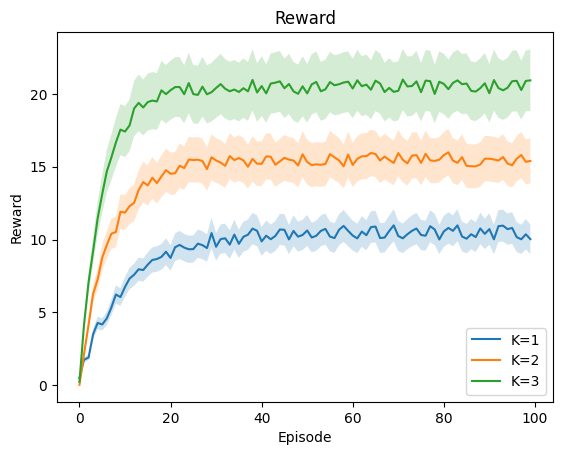

In [23]:
plot_histories(history_means, history_stds, history_names)